Split plaintext files into test train and validation

In [1]:
import os
import random

random.seed(13)
plaintext_directory = os.path.join("amlh_nlp_dataset", "amlh_nlp_dataset", "plaintext_data")
plaintext_fnames = [fname for fname in os.listdir(plaintext_directory) if fname.endswith(".txt")]

random.shuffle(plaintext_fnames)
val_index = int(0.1*len(plaintext_fnames))
test_index = val_index + int(0.2*len(plaintext_fnames))
fnames_val = plaintext_fnames[:val_index]
fnames_test = plaintext_fnames[val_index:test_index]
fnames_train = plaintext_fnames[test_index:]
print(len(fnames_train), len(fnames_val), len(fnames_test))

346 49 98


In [2]:
def preprocess_text(text):
    text = text.replace("\n ", "\n").replace("\n\n", " ").replace(":", " ").replace("  ", " ").lower()
    return text

def extract_centred_string(text, center_idx, length):
    lower_bound = max(0, center_idx - int(length/2))
    upper_bound = min(len(text), center_idx + int(length/2))
    center_idx = int(length/2) if lower_bound > 0 else center_idx
    return text[lower_bound:upper_bound], center_idx

def read_in_and_preprocess_plaintext(plaintext_directory, fnames, window_size, n_samples=10):
    text = []
    for fname in fnames:
        filepath = os.path.join(plaintext_directory, fname)
        with open(filepath, 'r', encoding="utf8") as plaintext_file:
            # Read in file and strip extraneous whitespace
            plaintext = plaintext_file.read()
            plaintext = preprocess_text(plaintext)
            for _ in range(n_samples):
                central_idx = random.randint(0, len(plaintext))
                extract, _ = extract_centred_string(plaintext, central_idx, window_size)
                text = text + [extract]
                
    return text


In [3]:
window_size = 256
text_train = read_in_and_preprocess_plaintext(plaintext_directory, fnames_train, window_size)
text_val = read_in_and_preprocess_plaintext(plaintext_directory, fnames_val, window_size)
text_test = read_in_and_preprocess_plaintext(plaintext_directory, fnames_test, window_size)

print(len(text_train), len(text_val), len(text_test))
print(text_train[0])

3460 490 980
harp dissection was carried down in the subcutaneous tissues and bovie electrocautery was used to reach the skull. a burr hole was placed down low using a craniotome. a craniotomy was turned and then enlarged as a craniectomy to at least 4 cm in diameter. 


Tokenise use Bert-Tokeniser

In [4]:
from transformers import BertTokenizerFast, BertForMaskedLM
import torch

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
inputs_train = tokenizer(text_train, return_tensors='pt', padding='max_length', max_length=128)
inputs_val = tokenizer(text_val, return_tensors='pt', padding='max_length', max_length=128)
inputs_test = tokenizer(text_test, return_tensors='pt', padding='max_length', max_length=128)

print(inputs_train.input_ids.size(), inputs_val.input_ids.size(), inputs_test.input_ids.size())
print(inputs_train.input_ids[0])

torch.Size([3460, 128]) torch.Size([490, 128]) torch.Size([980, 128])
tensor([  101, 14601,  4487, 11393,  7542,  2001,  3344,  2091,  1999,  1996,
         4942, 12690, 17191, 14095,  1998,  8945, 13469, 16175,  3540, 19901,
         2100,  2001,  2109,  2000,  3362,  1996,  7412,  1012,  1037, 22715,
         4920,  2001,  2872,  2091,  2659,  2478,  1037, 13675,  7088, 11439,
         4168,  1012,  1037, 13675,  7088, 11439,  8029,  2001,  2357,  1998,
         2059, 11792,  2004,  1037, 13675,  7088, 22471, 16940,  2000,  2012,
         2560,  1018,  4642,  1999,  6705,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,  

Create masked labels

In [5]:
def add_masked_labels_to_inputs(inputs):
    inputs['labels'] = inputs.input_ids.detach().clone()
    # create random array of floats with equal dimensions to input_ids tensor
    rand = torch.rand(inputs.input_ids.shape)
    # create mask array excluding masking special tokens
    mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * \
            (inputs.input_ids != 102) * (inputs.input_ids != 0)
    # Extract indicies to be masked
    selection = []
    for i in range(inputs.input_ids.shape[0]):
        selection.append(
            torch.flatten(mask_arr[i].nonzero()).tolist()
        )
    # Mask them
    for i in range(inputs.input_ids.shape[0]):
        inputs.input_ids[i, selection[i]] = 103
    return inputs

In [6]:
inputs_train = add_masked_labels_to_inputs(inputs_train)
inputs_val = add_masked_labels_to_inputs(inputs_val)
inputs_val = add_masked_labels_to_inputs(inputs_test)

In [7]:
print(inputs_train.labels.size(), inputs_val.labels.size(), inputs_test.labels.size())
print(inputs_train.labels[0])

torch.Size([3460, 128]) torch.Size([980, 128]) torch.Size([980, 128])
tensor([  101, 14601,  4487, 11393,  7542,  2001,  3344,  2091,  1999,  1996,
         4942, 12690, 17191, 14095,  1998,  8945, 13469, 16175,  3540, 19901,
         2100,  2001,  2109,  2000,  3362,  1996,  7412,  1012,  1037, 22715,
         4920,  2001,  2872,  2091,  2659,  2478,  1037, 13675,  7088, 11439,
         4168,  1012,  1037, 13675,  7088, 11439,  8029,  2001,  2357,  1998,
         2059, 11792,  2004,  1037, 13675,  7088, 22471, 16940,  2000,  2012,
         2560,  1018,  4642,  1999,  6705,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,  

Load into datasets and dataloaders

In [8]:
class MTSamplesDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return self.encodings.input_ids[idx], self.encodings.attention_mask[idx], self.encodings.labels[idx]
    def __len__(self):
        return len(self.encodings.input_ids)

In [9]:
datasets = {"train": MTSamplesDataset(inputs_train), "val": MTSamplesDataset(inputs_val), "test": MTSamplesDataset(inputs_test)}
dataloaders = {key: torch.utils.data.DataLoader(dataset, batch_size=8) for key, dataset in datasets.items()}
dataloaders["train"].shuffle = True

print([len(dataset) for dataset in datasets.values()])
print([len(dataloader) for dataloader in dataloaders.values()])

[3460, 980, 980]
[433, 123, 123]


Load model and optimiser

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model.to(device)
model.train()
print()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



In [11]:
from transformers import AdamW
# initialize optimizer
optim = AdamW(model.parameters(), lr=5e-5)

Run training

In [12]:
from tqdm import tqdm  # for our progress bar

num_steps = 100
loss_log = {"train":[], "val":[]}
optim.zero_grad()
with tqdm(total=num_steps) as pbar:
    for step in range(num_steps):
        # setup loop with TQDM and dataloader
        # loop = tqdm(num_steps, leave=True)
        for phase in ["train", "val"]:
            model = model.train() if phase == 'train' else model.eval()
            input_ids, attention_mask, labels = next(iter(dataloaders[phase]))
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(input_ids, attention_mask=attention_mask,
                            labels=labels)
                loss = outputs.loss
                if phase == 'train':
                    loss.backward()
                    optim.step()
                    optim.zero_grad()
            loss_log[phase].append(loss.item()/len(input_ids))
        # Print relevant info to progress bar
        pbar.update(1)
        pbar.set_description(f'Step number {step}')
        pbar.set_postfix(loss=loss_log["val"][-1])

Step number 99: 100%|██████████| 100/100 [00:21<00:00,  4.56it/s, loss=0.0362]


In [13]:
model_file = os.path.join("models", 'Bert_Finetuned_MTSamples.pt')
torch.save(model.state_dict(), model_file)

Text(0.5, 0, 'Num Steps')

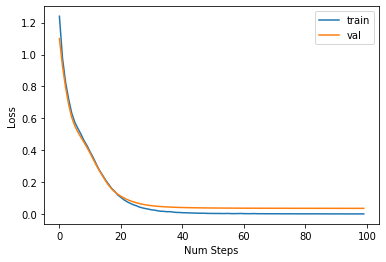

In [14]:
import matplotlib.pyplot as plt
for phase, loss in loss_log.items():
    plt.plot(loss[:100], label=phase)
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Num Steps")

In [71]:
def extract_text_from_annotations(annotations, plaintext_directory, window_size): 
    extracts = {"text": [], "idxs":[], "labels":[], "anno":[]}
    for _, anno in annotations.iterrows():
        anno_filepath = os.path.join(plaintext_directory, anno.file)
        anno_start = anno.start
        anno_length = anno.end - anno.start
        with open(anno_filepath, 'r', encoding="utf8") as plaintext_file:
            plaintext = plaintext_file.read()
            preprocessed_start = preprocess_text(plaintext[:anno_start])
            preprocessed_end = preprocess_text(plaintext[anno_start:])
            offset = len(plaintext[:anno_start]) - len(preprocessed_start)
            
            anno_start_pre = anno_start - offset
            plaintext = preprocessed_start + preprocessed_end
            extract, start_idx = extract_centred_string(plaintext, anno_start_pre, window_size)
            extracts["text"] += [extract]
            extracts["idxs"] += [[start_idx, start_idx+anno_length]]
            extracts["labels"] += [anno["class"]]
            extracts["anno"] += [extract[start_idx: start_idx+anno_length]]
    return extracts

In [72]:
import pandas as pd

annotations = pd.read_csv(os.path.join("amlh_nlp_dataset", "amlh_nlp_dataset","amlh_coursework_annotated.csv"))
annotations_train = annotations[annotations.file.isin(fnames_train+fnames_val)]
annotations_test = annotations[annotations.file.isin(fnames_test)]

extracts_train = extract_text_from_annotations(annotations_train, plaintext_directory, window_size)
extracts_test = extract_text_from_annotations(annotations_test, plaintext_directory, window_size)

print([len(feature) for feature in extracts_train.values()])
print([len(feature) for feature in extracts_test.values()])

[12694, 12694, 12694, 12694]
[2962, 2962, 2962, 2962]


In [73]:
inputs_train = tokenizer(extracts_train["text"], return_tensors='pt', padding='max_length', max_length=128, return_offsets_mapping=True)
inputs_test = tokenizer(extracts_test["text"], return_tensors='pt', padding='max_length', max_length=128, return_offsets_mapping=True)

extracts_train = {**extracts_train, **inputs_train}
extracts_test = {**extracts_test, **inputs_test}

print(inputs_train.input_ids.size(), inputs_test.input_ids.size())

torch.Size([12694, 128]) torch.Size([2962, 128])


In [80]:
import numpy as np

def get_tokens_of_interest_idxs(offset_mapping_list, idxs_list, text, annos):
    toi_idxs = []
    for offset_mapping, idxs, text, anno in zip(offset_mapping_list, idxs_list, text, annos):
        try:
            token_start = np.where(offset_mapping[:, 0]==idxs[0])[0][0]
            token_end = np.where(offset_mapping[:, 1]==idxs[1])[0][0]
            toi_idxs.append([token_start, token_end])
        except:
            print("In text: " + text[idxs[0]:idxs[1]+3], "Annotation: " + anno)
            toi_idxs.append([token_start, token_start+1])
    return toi_idxs
get_tokens_of_interest_idxs(extracts_train["offset_mapping"], extracts_train["idxs"], extracts_train["text"], extracts_train["anno"])

In text: cannot Annotation: can
In text: cannot Annotation: can
In text: cannot Annotation: can
In text: cannot Annotation: can
In text: cannot Annotation: can
In text: cannot Annotation: can
In text: cannot Annotation: can
In text: cannot Annotation: can
In text: cannot Annotation: can
In text: cannot Annotation: can
In text: cannot Annotation: can
In text: cannot Annotation: can
In text: cannot Annotation: can
In text: cannot Annotation: can
In text: cannot Annotation: can
In text: cannot Annotation: can
In text: cannot Annotation: can
In text: cannot Annotation: can
In text: cannot Annotation: can
In text: cannot Annotation: can
In text: cannot Annotation: can


[[28, 29],
 [28, 31],
 [43, 43],
 [26, 27],
 [24, 25],
 [37, 38],
 [36, 37],
 [7, 7],
 [11, 16],
 [20, 21],
 [33, 36],
 [40, 41],
 [49, 50],
 [49, 50],
 [49, 52],
 [39, 40],
 [39, 43],
 [39, 40],
 [31, 34],
 [26, 27],
 [26, 29],
 [25, 26],
 [27, 28],
 [28, 29],
 [30, 30],
 [28, 33],
 [33, 38],
 [36, 37],
 [37, 38],
 [36, 36],
 [33, 38],
 [36, 42],
 [25, 30],
 [29, 32],
 [45, 46],
 [30, 34],
 [28, 28],
 [31, 31],
 [31, 31],
 [31, 34],
 [30, 32],
 [32, 32],
 [29, 32],
 [26, 29],
 [33, 33],
 [32, 32],
 [27, 27],
 [25, 25],
 [27, 28],
 [24, 25],
 [27, 27],
 [36, 36],
 [38, 38],
 [31, 35],
 [30, 33],
 [30, 31],
 [25, 27],
 [27, 27],
 [26, 29],
 [28, 28],
 [30, 30],
 [33, 36],
 [2, 3],
 [35, 37],
 [30, 30],
 [29, 30],
 [16, 17],
 [28, 30],
 [25, 26],
 [31, 34],
 [24, 26],
 [32, 34],
 [24, 25],
 [32, 34],
 [29, 29],
 [29, 29],
 [29, 30],
 [36, 36],
 [32, 33],
 [33, 34],
 [33, 33],
 [32, 32],
 [32, 32],
 [28, 29],
 [30, 37],
 [37, 38],
 [0, 1],
 [28, 29],
 [32, 32],
 [32, 33],
 [29, 29],
 [29,

In [99]:
class MT_NERSamplesDataset(torch.utils.data.Dataset):
    def __init__(self, extracts):
        self.extracts = extracts
    def __getitem__(self, idx):
        return {key: value[idx] for key, value in self.extracts.items()}
    def __len__(self):
        return len(self.extracts["input_ids"])
    def get_phrase(sample):
        text = sample["text"]
        idxs = sample["idxs"]
        return text[idxs[0]:idxs[1]]

In [102]:
datasets = {"train": MT_NERSamplesDataset(extracts_train), "test": MT_NERSamplesDataset(extracts_test)}
dataloaders = {key: torch.utils.data.DataLoader(dataset, batch_size=8) for key, dataset in datasets.items()}

print([len(dataset) for dataset in datasets.values()])
print([len(dataloader) for dataloader in dataloaders.values()])
sample = datasets["train"][0]
print(sample.keys())
print(MT_NERSamplesDataset.get_phrase(sample))

[14218, 1438]
[1778, 180]
dict_keys(['text', 'idxs', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'])
colon cancer


In [126]:
# feature_vectors = torch.zeros()
# for phase in ["train", "test"]:
model = model.eval()
batch = next(iter(dataloaders["train"]))
input_ids = batch["input_ids"].to(device)
print(len(input_ids))
attention_mask = batch["attention_mask"].to(device)
with torch.set_grad_enabled(False):
    outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
print(outputs.hidden_states[-1].size())

8
torch.Size([8, 128, 768])
